In [3]:
import pandas as pd
import numpy as np
import os
import logging
import datetime
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import Parallel, delayed
from pathlib import Path
from collections import namedtuple

In [48]:
Trajectory = namedtuple(
    "Trajectory", ["start", "reaching", "reached", "grasping", "lifting", "holding"]
)

selections = {  # index, offset, length
    "full": [1, 0.0, 8.5],
    "reaching": [1, 0.0, 2.0],
    "grasp": [3, 0.0, 4.0],
    "lift": [4, 0.0, 0.75],
    "hold": [4, 2.0, 1.25],
    "lift_hold": [4, 0.0, 2.0],
    "grasp_lift": [3, 0.0, 4.75],
    "grasp_lift_hold": [3, 0.0, 6.5]
}

class Modes:
    TACT, VIS = range(2)

def read_tactile_file(tactile_path, obj_name):
    """Reads a tactile file from path. Returns a pandas dataframe."""
    obj_path = Path(tactile_path) / f"{obj_name}.tact"
    df = pd.read_csv(
        obj_path,
        delimiter=" ",
        names=["polarity", "cell_index", "timestamp_sec", "timestamp_nsec"],
        dtype=int,
    )
    df = df.assign(timestamp=df.timestamp_sec + df.timestamp_nsec / 1000000000)
    df = df.drop(["timestamp_sec", "timestamp_nsec"], axis=1)
    return df


def read_trajectory(trajectory_path, obj_name, start_time=None, zeroed=False):
    """Reads the trajectory from path, Returns a Trajectory."""
    obj_path = Path(trajectory_path) / f"{obj_name}.startend"
    with open(obj_path, "r") as f:
        timings = list(map(float, f.read().split(" ")))
        if start_time is not None:
            delta = start_time - timings[0]
            timings = [t + delta for t in timings]
        if zeroed:
            start_time = timings[0]
            timings = [t - start_time for t in timings]
        return Trajectory(*timings)

trajectory_path = '/datasets/eventdata/batch2/traj_start_ends/'
tactile_path = '/datasets/eventdata/batch2/aces_recordings/'

    
class TactileData:
    def __init__(self, obj_name, selection):
        assert selection in selections
        self.obj_name = obj_name
        self.trajectory = read_trajectory(trajectory_path, obj_name)
        self.df = read_tactile_file(tactile_path, obj_name)

        traj_start, offset, self.T = selections[selection]
        self.start_t = self.trajectory[traj_start] + offset
        self.threshold = 1

    def binarize(self, bin_duration):
        bin_number = int(np.floor(self.T / bin_duration))
        data_matrix = np.zeros([80, 2, bin_number], dtype=int)

        pos_df = self.df[self.df.polarity == 1]
        neg_df = self.df[self.df.polarity == 0]

        end_t = self.start_t + bin_duration
        count = 0

        init_t = self.start_t
        
        print(self.df)
        
        print(self.start_t, end_t)
        

        while end_t <= self.T + init_t:  # start_t <= self.T
            _pos_count = pos_df[
                ((pos_df.timestamp >= self.start_t) & (pos_df.timestamp < end_t))
            ]
            _pos_selective_cells = _pos_count.cell_index.value_counts() > self.threshold
            print(_pos_selective_cells)
            if len(_pos_selective_cells):
                data_matrix[
                    _pos_selective_cells[_pos_selective_cells].index.values - 1,
                    0,
                    count,
                ] = 1

            _neg_count = neg_df[
                ((neg_df.timestamp >= self.start_t) & (neg_df.timestamp < end_t))
            ]
            _neg_selective_cells = _neg_count.cell_index.value_counts() > self.threshold
            if len(_neg_selective_cells):
                data_matrix[
                    _neg_selective_cells[_neg_selective_cells].index.values - 1,
                    1,
                    count,
                ] = 1
            self.start_t = end_t
            end_t += bin_duration
            count += 1

        data_matrix = np.delete(data_matrix, [16, 48], 0)
        return data_matrix

In [49]:
td = TactileData("107-a_pepsi_bottle_01", 'grasp_lift_hold')

In [50]:
a = td.binarize(0.02)

       polarity  cell_index     timestamp
0             0          61  1.579159e+09
1             0          22  1.579159e+09
2             0          11  1.579159e+09
3             0          74  1.579159e+09
4             0          22  1.579159e+09
...         ...         ...           ...
20541         1          78  1.579159e+09
20542         1          36  1.579159e+09
20543         1           3  1.579159e+09
20544         1          35  1.579159e+09
20545         0          57  1.579159e+09

[20546 rows x 3 columns]
1579158586.18 1579158586.2
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_index, dtype: bool)
Series([], Name: cell_i

8      True
6      True
15     True
10     True
40     True
41     True
9      True
63     True
58     True
66     True
5     False
71    False
2     False
4     False
67    False
73    False
13    False
78    False
1     False
16    False
25    False
21    False
62    False
28    False
31    False
33    False
37    False
45    False
7     False
51    False
53    False
54    False
56    False
57    False
59    False
61    False
64    False
Name: cell_index, dtype: bool
15     True
32     True
57     True
66     True
9      True
16     True
72     True
73     True
40     True
33     True
37     True
63    False
12    False
77    False
8     False
11    False
21    False
71    False
5     False
4     False
67    False
2     False
30    False
24    False
28    False
58    False
31    False
34    False
54    False
69    False
39    False
41    False
68    False
19    False
53    False
52    False
76    False
13    False
7     False
Name: cell_index, dtype: bool
57     True
65     True
4   

4      True
14     True
57     True
58     True
78     True
15     True
24     True
28     True
29     True
39    False
54    False
56    False
7     False
9     False
10    False
11    False
76    False
47    False
38    False
43    False
25    False
42    False
40    False
33    False
36    False
1     False
Name: cell_index, dtype: bool
15     True
33     True
19     True
57     True
56     True
54     True
40     True
4      True
36     True
28     True
14    False
24    False
2     False
5     False
9     False
78    False
30    False
25    False
29    False
58    False
31    False
32    False
37    False
38    False
39    False
65    False
Name: cell_index, dtype: bool
25     True
56     True
15     True
19     True
31     True
33     True
10     True
14     True
24     True
28     True
65     True
36     True
37     True
35    False
57    False
38    False
39    False
43    False
47    False
54    False
78    False
4     False
2     False
58    False
Name: cell_index, dtype: boo

78     True
57     True
15     True
14     True
33     True
21     True
39     True
16     True
19     True
25     True
28     True
31     True
34     True
40     True
54     True
56     True
58     True
65     True
32    False
61    False
30    False
38    False
24    False
41    False
10    False
9     False
3     False
Name: cell_index, dtype: bool
15     True
14     True
21     True
31     True
34     True
9      True
10     True
78     True
25     True
58     True
65     True
43     True
56     True
57     True
35    False
38    False
39    False
40    False
30    False
41    False
19    False
54    False
55    False
76    False
8     False
2     False
33    False
Name: cell_index, dtype: bool
65     True
36     True
57     True
56     True
15     True
21     True
25     True
31     True
33     True
78     True
16     True
30     True
35     True
34     True
50     True
38     True
39     True
54     True
55    False
2     False
3     False
9     False
73    False
59    False
37  

65     True
57     True
21     True
34     True
35     True
18     True
25     True
56     True
58     True
19    False
14    False
16    False
28    False
33    False
10    False
39    False
38    False
54    False
36    False
31    False
Name: cell_index, dtype: bool
35     True
25     True
28     True
57     True
58     True
34     True
14     True
21     True
33     True
31     True
38     True
36    False
39    False
40    False
50    False
19    False
18    False
56    False
10    False
78    False
3     False
2     False
65    False
Name: cell_index, dtype: bool
56     True
28     True
57     True
35     True
40     True
14     True
34     True
25     True
59    False
3     False
8     False
9     False
16    False
21    False
24    False
33    False
30    False
31    False
58    False
36    False
37    False
38    False
41    False
47    False
2     False
Name: cell_index, dtype: bool
57     True
28     True
16     True
56     True
2      True
38     True
35     True
31     Tru

In [51]:
a.shape

(78, 2, 325)

In [52]:
np.unique(a, return_counts=True)

(array([0, 1]), array([45189,  5511]))

In [64]:
tact_npy = '/home/tasbolat/some_python_examples/data_VT_SNN/0_tact.npy'
b = np.load(tact_npy)

In [65]:
bsum= np.sum(np.sum(b,axis=0),axis=0)
asum= np.sum(np.sum(a,axis=0),axis=0)

In [66]:
bsum

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 12, 17, 26, 34, 44, 40, 18, 47, 53, 51,
       49, 55, 50, 48, 49, 48, 47, 52, 42, 51, 53, 56, 50, 55, 50, 51, 54,
       55, 54, 43, 42, 47, 49, 47, 46, 42, 45, 41, 45, 48, 49, 47, 43, 42,
       43, 46, 41, 42, 45, 42, 42, 29, 17, 16, 19, 25, 12, 17, 15, 18, 27,
       21, 16, 17, 17, 12, 16, 18, 17, 18, 19, 19, 18, 12, 22, 18, 18, 18,
       20, 19, 13, 15, 15, 13, 20, 16, 15, 19, 16, 15, 13, 20, 18, 14, 18,
       42,  0, 57, 43, 50, 45, 49, 56, 47, 46, 46, 45, 42, 43, 28, 25, 31,
       26, 38, 28, 26, 26

In [67]:
asum

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 12, 17, 26, 34, 44, 40, 18, 47, 53, 51,
       49, 55, 50, 48, 49, 48, 47, 52, 42, 51, 53, 56, 50, 55, 50, 51, 54,
       55, 54, 43, 42, 47, 49, 47, 46, 42, 45, 41, 45, 48, 49, 47, 43, 42,
       43, 46, 41, 42, 45, 42, 42, 29, 17, 16, 19, 25, 12, 17, 15, 18, 27,
       21, 16, 17, 17, 12, 16, 18, 17, 18, 19, 19, 18, 12, 22, 18, 18, 18,
       20, 19, 13, 15, 15, 13, 20, 16, 15, 19, 16, 15, 13, 20, 18, 14, 18,
       42,  0, 57, 43, 50, 45, 49, 56, 47, 46, 46, 45, 42, 43, 28, 25, 31,
       26, 38, 28, 26, 26

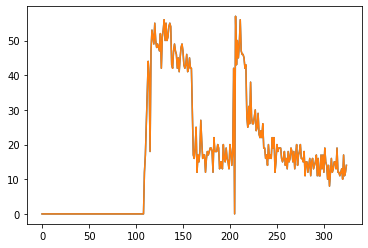

In [68]:
import matplotlib.pyplot as plt
plt.plot(asum)
plt.plot(bsum)